# Random Forest Regression Algorithm - Raw Data Training

In [17]:
# Importing the libraries
import time
import numpy as np # for array operations
import pandas as pd # for working with DataFrames

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [18]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

dataset = pd.read_csv('../../../data/dataset.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

## Required Preprocessing

In [19]:
dataset["DATETIME_INI"] = dataset["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
dataset["DATETIME_FIM"] = dataset["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [ ]:
dataset.head()

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['TPVEICULO_DESC'] = label_encoder.fit_transform(dataset['TPVEICULO_DESC'])
dataset['TPCIRCUITO_DESC'] = label_encoder.fit_transform(dataset['TPCIRCUITO_DESC'])
dataset['ROTA_ID'] = label_encoder.fit_transform(dataset['ROTA_ID'])
dataset['ROTA_DESC'] = label_encoder.fit_transform(dataset['ROTA_DESC'])
dataset['LOCDESCARREGO_DESC'] = label_encoder.fit_transform(dataset['LOCDESCARREGO_DESC'])
dataset['LOCAL_NOME'] = label_encoder.fit_transform(dataset['LOCAL_NOME'])
dataset['COLETA_DESC'] = label_encoder.fit_transform(dataset['COLETA_DESC'])
dataset['ESPECCOLETA_DESC'] = label_encoder.fit_transform(dataset['ESPECCOLETA_DESC'])
dataset['EMP_NOME'] = label_encoder.fit_transform(dataset['EMP_NOME'])

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119801 entries, 2490322 to 2384221
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   LOCDESCARREGO_ID    119801 non-null  int64  
 1   LOCDESCARREGO_DESC  119801 non-null  int32  
 2   EMP_ID              119801 non-null  int64  
 3   EMP_NOME            119801 non-null  int32  
 4   ROTA_ID             119801 non-null  int32  
 5   TPVEICULO_DESC      119801 non-null  int32  
 6   PES_PESOINI         119801 non-null  int64  
 7   PES_PESOFIM         119801 non-null  int64  
 8   PES_PESOUTIL        119801 non-null  int64  
 9   COLETA_ID           119801 non-null  int64  
 10  COLETA_DESC         119801 non-null  int32  
 11  ESPECCOLETA_ID      119801 non-null  int64  
 12  ESPECCOLETA_DESC    119801 non-null  int32  
 13  PERCUSSO_I          119801 non-null  float64
 14  LOCAL_ID            119801 non-null  int64  
 15  ROTA_DESC           119801 non-n

## Training

In [22]:
x = dataset.drop('PES_PESOUTIL', axis = 1) # Features
y = dataset['PES_PESOUTIL']  # Target

In [23]:
# Splitting the dataset into training and testing set (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

### Parameterizing

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # set up our search grid
# param_grid = {"n_estimators": range(1, 50),
#               "criterion": ["squared_error", "mean_squared_error", "absolute_error"],
#               "max_depth": [4, 5, 6]
# }

# rfr_model = RandomForestRegressor()

# # try out every combination of the above values
# search = GridSearchCV(rfr_model, param_grid, cv=10).fit(x_train, y_train)

# print("The best hyperparameters are ",search.best_params_)


In [24]:
params = {
    'n_estimators': 50,
    'criterion': 'squared_error',
    'max_depth': 5,
    'random_state': 0,
}

In [25]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(**params)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)

In [26]:
# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, model.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 567912.5687


## Cross-Validation

In [27]:
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    n_scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    return n_scores

## Experimentation

In [28]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

n_scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    n_scores.append(cross_validate_model(model, x, y, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

### Training Duration

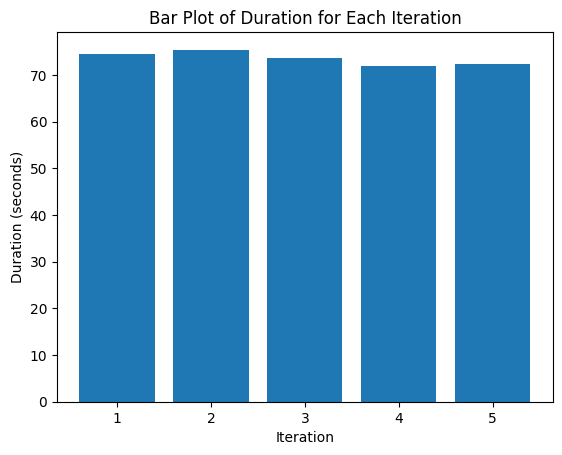

In [29]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()


### R² Score

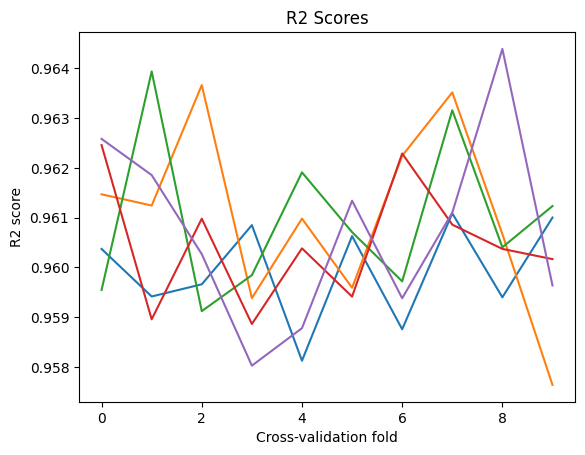

In [30]:
import matplotlib.pyplot as plt

# Reshape the R2 scores
r2_scores = [r2['test_r2'].reshape(-1, 1) for r2 in n_scores]

# Plot the R2 scores
[plt.plot(r2_score, label=f'Fold {i + 1}') for i, r2_score in enumerate(r2_scores)]
plt.xlabel('Cross-validation fold')
plt.ylabel('R2 score')
plt.title('R2 Scores')
plt.show()

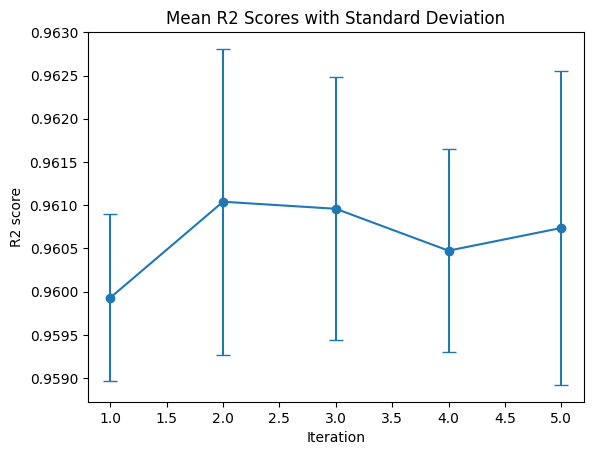

Mean R2: 0.9606
Standard Deviation of R2: 0.0004


In [31]:
# Calculate mean and standard deviation of R2 scores
mean_r2_scores = [r2['test_r2'].mean() for r2 in n_scores]
std_r2_scores = [r2['test_r2'].std() for r2 in n_scores]

# Plot the mean R2 scores with error bars representing the standard deviation
plt.errorbar(range(1, N_ITERATIONS + 1), mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Mean R2 Scores with Standard Deviation')
plt.show()

mean_r2 = sum(mean_r2_scores) / len(mean_r2_scores)
std_mse = np.std(mean_r2_scores)

print("Mean R2: {:.4f}".format(mean_r2))
print("Standard Deviation of R2: {:.4f}".format(std_mse))

### MSE

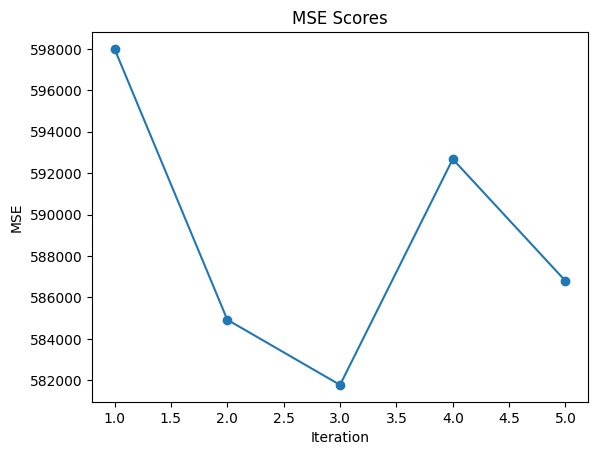

Mean MSE: 588831.9183
Standard Deviation of MSE: 5796.0878


In [32]:
# Calculate MSE for each fold
mse_scores = [-r2['test_neg_mean_squared_error'].mean() for r2 in n_scores]

# Plot the MSE scores
plt.plot(range(1, N_ITERATIONS + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE Scores')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

### RMSE

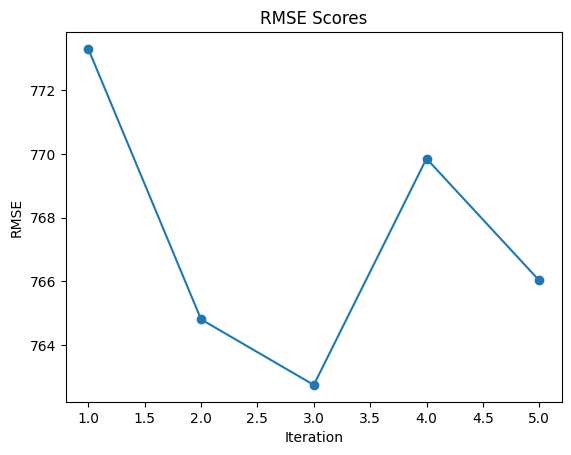

Mean RMSE: 767.3446
Standard Deviation of RMSE: 3.7729


In [33]:
rmse_scores = [np.sqrt(-r2['test_neg_mean_squared_error'].mean()) for r2 in n_scores]

# Plot the RMSE scores
plt.plot(range(1, N_ITERATIONS + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))